In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

import os
from torchsummary import summary
import time

### README
預先把dataset存到list中，可用gpu，速度蠻快的

---

1. 看要在cpu or gpu

In [2]:
# test if GPU can use?
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


2. 超參數

In [4]:
# Hyper Parameters
LR = 0.02
batch_size_train = 10
batch_size_valid = 5
# n_iters = 10000
NUM_EPOCHS = 25

IMAGE_SIZE = 128

3. 讀取LA_train_info

In [5]:
train_df = pd.read_csv("train_info.csv")

In [6]:
train_df.head()

,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_1138215,-,bonafide,D:/graduate_project/src/asvpoof-2019-dataset/L...,0
1,LA_0079,LA_T_1271820,-,bonafide,D:/graduate_project/src/asvpoof-2019-dataset/L...,0
2,LA_0079,LA_T_1272637,-,bonafide,D:/graduate_project/src/asvpoof-2019-dataset/L...,0
3,LA_0079,LA_T_1276960,-,bonafide,D:/graduate_project/src/asvpoof-2019-dataset/L...,0
4,LA_0079,LA_T_1341447,-,bonafide,D:/graduate_project/src/asvpoof-2019-dataset/L...,0


4. function : 刪除圖片空白處

Before Cropped:


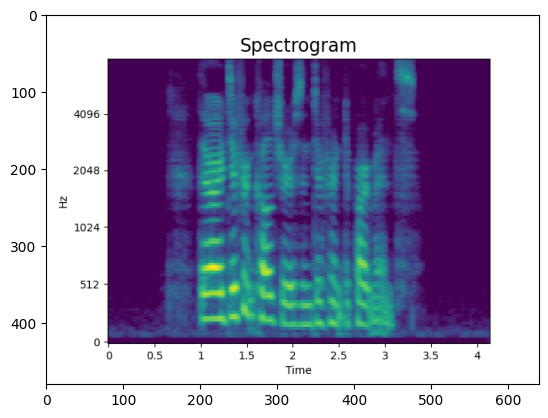

After Cropped:


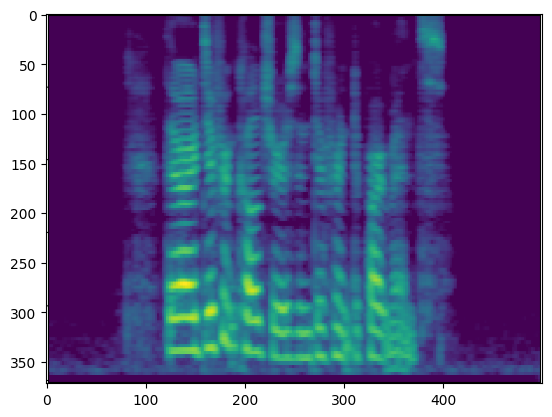

In [24]:
def remove_margin(image_path):
    # Load the image
    img = Image.open(image_path)
    img2 = np.array(img)

    # Find the bounding box of the non-background region
    non_bg_indices = np.argwhere(img2 != 255)  # Assuming the background is white (255)
    min_row, min_col, _ = np.min(non_bg_indices, axis=0)
    max_row, max_col, _ = np.max(non_bg_indices, axis=0)

    # Crop the image to the bounding box
    cropped_img = img2[min_row + 25:max_row-38, min_col + 61:max_col+1] # 自行調數值刪掉空白


    return img, cropped_img

# Example usage
image_path = "D:/graduate_project/src/spec_LATrain_audio_shuffle1_NOT_preprocessing\\spec_LA_T_1007571.png"
img, cropped_img = remove_margin(image_path)

# Display the image before cropped
print("Before Cropped:")
plt.imshow(img, cmap='gray')
# plt.axis('off')
plt.show()

# Display the cropped image
print("After Cropped:")
plt.imshow(cropped_img, cmap='gray')
# plt.axis('off')
plt.show()


5. 設定dataset，包含設定transformer、分成70% / 30%，圖片轉換處理完直接存到list，(沒有做成pytorch中的dataset)

In [55]:
# Assuming you have defined the 'spectrogram_images_train' folder and transform
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Original Size: (640, 480)
    transforms.ToTensor()
])

# Load Images from a Folder
image_folder_path = "D:/graduate_project/src/spec_LATrain_audio_shuffle1_NOT_preprocessing"

image_paths = [os.path.join(image_folder_path, filename) for filename in os.listdir(image_folder_path)]

# Load Labels
# Assuming 'train_df' has columns 'filename' and 'target'
# skip the "spec_" and ".png"
labels = [train_df[train_df["filename"] == os.path.basename(path)[5:-4]]["target"].values[0] for path in image_paths]

# Apply Transformations
# get the cropped image
# Convert the NumPy array back to an image
images = [transform(Image.fromarray(remove_margin(path)[1].astype('uint8')).convert('RGB')) for path in image_paths]
# images = [transform(Image.open(path).convert('RGB')) for path in image_paths]

# Create TensorDataset
train_data = torch.utils.data.TensorDataset(torch.stack(images), torch.tensor(labels, dtype=torch.long))

# Define Train and Validation Sizes
train_size = int(0.7 * len(train_data))
valid_size = len(train_data) - train_size

# Split into train and validation sets
train_dataset, valid_dataset = torch.utils.data.random_split(train_data, [train_size, valid_size])

# Create DataLoader for train and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size_valid, shuffle=False)


In [56]:
# 圖片原始大小
image_path = image_paths[1]
image = Image.open(image_path).convert('RGB')
original_size = image.size

print("Original Size:", original_size)

Original Size: (640, 480)


In [57]:
len(valid_loader)

60

In [58]:
image_paths[:5]

['D:/graduate_project/src/spec_LATrain_audio_shuffle1_NOT_preprocessing\\spec_LA_T_1007571.png',
 'D:/graduate_project/src/spec_LATrain_audio_shuffle1_NOT_preprocessing\\spec_LA_T_1010949.png',
 'D:/graduate_project/src/spec_LATrain_audio_shuffle1_NOT_preprocessing\\spec_LA_T_1011221.png',
 'D:/graduate_project/src/spec_LATrain_audio_shuffle1_NOT_preprocessing\\spec_LA_T_1016062.png',
 'D:/graduate_project/src/spec_LATrain_audio_shuffle1_NOT_preprocessing\\spec_LA_T_1023546.png']

Show the image

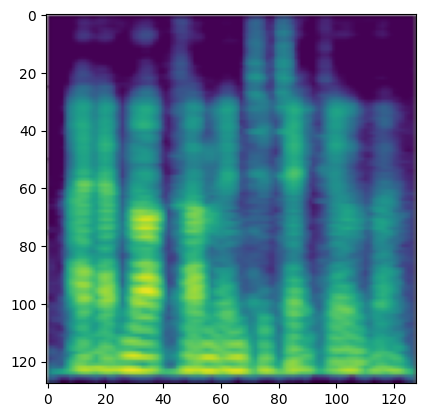

In [59]:
# Assuming 'image_tensor' is your tensor with shape [3, 128, 128]

# Convert the tensor to a NumPy array and permute the dimensions
image_array = images[1].permute(1, 2, 0).numpy()  # Assuming you want to visualize the first image in the batch

# If you are using a batch of images, you might want to loop through them
# for i in range(image_tensor.shape[0]):
#     image_array = image_tensor[i].permute(1, 2, 0).numpy()

# Display the image using Matplotlib
plt.imshow(image_array)
plt.show()


In [60]:
images[0].shape

torch.Size([3, 128, 128])

In [61]:
len(images)

1000

In [62]:
# for i, j in zip(image_paths, labels):
#     print(i, j)

6. model1 - CNN model

- For 256 * 256 image size

In [63]:
# # define CNN model
# class MyCNN(nn.Module):
#     def __init__(self):
#         super(MyCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32 ,3) # get 32 x 254 x 254
#         self.pool1 = nn.MaxPool2d(2,2) # get 32 x 127 x 127
#         self.conv2 = nn.Conv2d(32, 64 ,4) # get 64 x 125 x 125
#         self.pool2 = nn.MaxPool2d(2,2) # get 64 x 62 x 62
#         self.conv3 = nn.Conv2d(64, 128 ,3) # get 128 x 60 x 60
#         self.pool3 = nn.MaxPool2d(2,2) # get 128 x 30 x 30
#         # Flatten layers
#         self.fc1 = nn.Linear(115200, 512) 
#         self.fc2 = nn.Linear(512, 2) 

#         # introducing dropout layer to prevent overfitting
#         self.dropout = nn.Dropout(0.25)

#     def forward(self, x):
#         x = funcs.relu(self.conv1(x)) # apply RelU
#         x = self.pool1(x)
#         x = self.dropout(x)
        
#         x = funcs.relu(self.conv2(x)) # apply RelU
#         x = self.pool2(x)
#         x = self.dropout(x)
        
#         x = funcs.relu(self.conv3(x)) # apply RelU
#         x = self.pool3(x)
#         x = self.dropout(x)
        
#         x = x.view(-1, 115200) # flatten
#         x = funcs.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = (self.fc2(x))
#         return x

# # set up a model to trainning
# model = MyCNN()
# print(model)

# # print('Before saveing: ')
# # print(model.state_dict())

# # Print the model summary
# summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))  # Input size: (channels, height, width)

- For 128 * 128 image size

In [68]:
# define CNN model
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32 ,3) # get 32 x 126 x 126
        self.pool1 = nn.MaxPool2d(2,2) # get 32 x 63 x 63
        self.conv2 = nn.Conv2d(32, 64 ,4) # get 64 x 60 x 60
        self.pool2 = nn.MaxPool2d(2,2) # get 64 x 30 x 30
        self.conv3 = nn.Conv2d(64, 128 ,3) # get 128 x 28 x 28
        self.pool3 = nn.MaxPool2d(2,2) # get 128 x 14 x 14
        # Flatten layers
        self.fc1 = nn.Linear(25088, 512) 
        self.fc2 = nn.Linear(512, 2) 

        # introducing dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # apply RelU
        x = self.pool1(x)
        x = self.dropout(x)
        
        x = F.relu(self.conv2(x)) # apply RelU
        x = self.pool2(x)
        x = self.dropout(x)
        
        x = F.relu(self.conv3(x)) # apply RelU
        x = self.pool3(x)
        x = self.dropout(x)
        
        x = x.view(-1, 25088) # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = (self.fc2(x))
        return x

# set up a model , turn model into cuda
model = MyCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)   # optimize all cnn parameters

# Print the model summary
summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))  # Input size: (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             896
         MaxPool2d-2           [-1, 32, 63, 63]               0
           Dropout-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 60, 60]          32,832
         MaxPool2d-5           [-1, 64, 30, 30]               0
           Dropout-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
         MaxPool2d-8          [-1, 128, 14, 14]               0
           Dropout-9          [-1, 128, 14, 14]               0
           Linear-10                  [-1, 512]      12,845,568
          Dropout-11                  [-1, 512]               0
           Linear-12                    [-1, 2]           1,026
Total params: 12,954,178
Trainable params: 12,954,178
Non-trainable params: 0
-------------------------

7. 訓練模型

Epoch [1/25], Train Loss: 0.6902, Train Accuracy: 54.86%, Valid Loss: 0.6820, Valid Accuracy: 66.33%
Epoch [1/25] took 4.478532791137695 seconds
Epoch [2/25], Train Loss: 0.6602, Train Accuracy: 59.71%, Valid Loss: 0.6288, Valid Accuracy: 65.33%
Epoch [2/25] took 4.206370830535889 seconds
Epoch [3/25], Train Loss: 0.6055, Train Accuracy: 64.57%, Valid Loss: 0.5899, Valid Accuracy: 67.67%
Epoch [3/25] took 4.155101299285889 seconds
Epoch [4/25], Train Loss: 0.5634, Train Accuracy: 69.57%, Valid Loss: 0.5704, Valid Accuracy: 71.00%
Epoch [4/25] took 4.2375571727752686 seconds
Epoch [5/25], Train Loss: 0.5656, Train Accuracy: 67.57%, Valid Loss: 0.5620, Valid Accuracy: 71.67%
Epoch [5/25] took 4.159214973449707 seconds
Epoch [6/25], Train Loss: 0.5598, Train Accuracy: 70.71%, Valid Loss: 0.5838, Valid Accuracy: 70.00%
Epoch [6/25] took 4.160545110702515 seconds
Epoch [7/25], Train Loss: 0.5420, Train Accuracy: 70.57%, Valid Loss: 0.5373, Valid Accuracy: 72.33%
Epoch [7/25] took 4.17614555

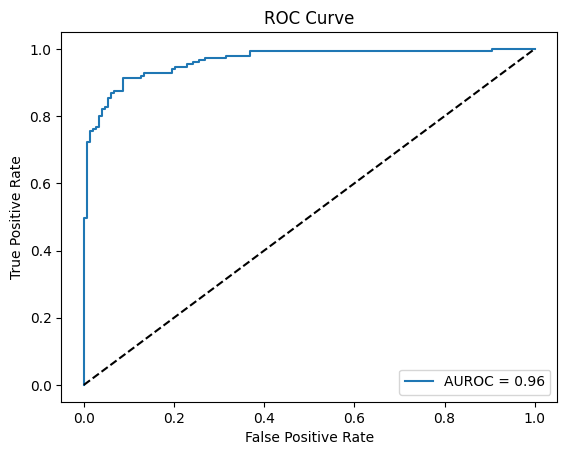

[[131  18]
 [ 13 138]]
Total training time: 105.73380756378174 seconds


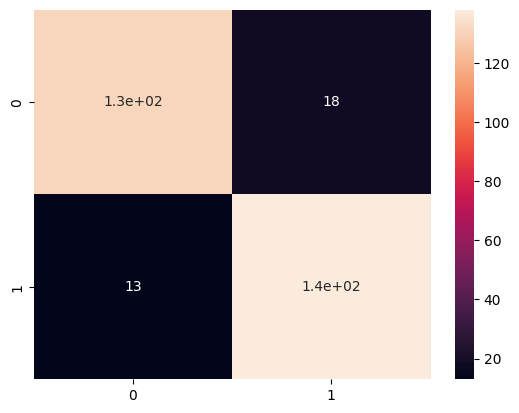

In [65]:
# store loss and acc data
Total_training_loss = []
Total_training_accuracy = []
Total_validation_loss = []
Total_validation_accuracy = []
    
# 訓練模型
def training(model):
    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()

        model.train() # 訓練模式
        train_loss = 0.0
        total_train = 0
        correct_train = 0
        for _, (image, label) in  enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            image, label = image.to(device), label.to(device)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(image)
            # calculate the batch loss
            loss = criterion(outputs, label)
            
            loss.backward()
            # Update the parameters
            optimizer.step()
            
            # update training loss
            train_loss += loss.item()*image.size(0)
            
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            total_train += label.size(0)
            correct_train += (predicted == label).sum().item()
          
        model.eval() # 改變成測試模式
        valid_loss = 0.0
        correct = 0
        total = 0
        all_probs = []
        all_pred = []
        all_label = []
        with torch.no_grad():
            for _, (image, label) in enumerate(valid_loader):
                # move tensors to GPU if CUDA is available
                image, label = image.to(device), label.to(device)

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(image)
                # calculate the batch loss
                loss =criterion(output, label)
                # update training loss
                valid_loss += loss.item()*image.size(0)

                probs = torch.nn.functional.softmax(output, dim=1)
                _, predicted = torch.max(probs, 1)

                # Extract the probabilities for class 1 (positive class)
                probs_class_1 = np.array(probs.cpu())[:, 1] # for draw the roc

                all_probs.extend(probs_class_1)
                all_pred.extend(predicted.cpu().numpy())
                all_label.extend(label.cpu().numpy())
                total += label.size(0)
                correct += (predicted == label).sum().item()

            # 計算每個樣本的平均損失
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)
            Total_training_loss.append(train_loss)
            Total_validation_loss.append(valid_loss)
            
        # 計算準確率
        accuracy_train = 100 * correct_train / total_train
        accuracy_valid = 100 * correct / total
        Total_training_accuracy.append(accuracy_train)
        Total_validation_accuracy.append(accuracy_valid)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS:d}], Train Loss: {train_loss:.4f}, Train Accuracy: {accuracy_train:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {accuracy_valid:.2f}%')

        # 計算此epoch花的時間
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS:d}] took {epoch_time} seconds")

    # 計算 AUROC
    roc_auc = roc_auc_score(all_label, all_probs)
        
    # 繪製 ROC 曲線
    fpr, tpr, _ = roc_curve(all_label, all_probs)
    plt.plot(fpr, tpr, label='AUROC = {:.2f}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()     
        
    # confusion_matrix
    cm = confusion_matrix(all_label, all_pred)
    print(cm)
    sns.heatmap(cm, annot=True)

# Start training
if __name__ == "__main__":
    # 初始時間
    start_time = time.time()

    training(model)

    # 計算總時間
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time} seconds")

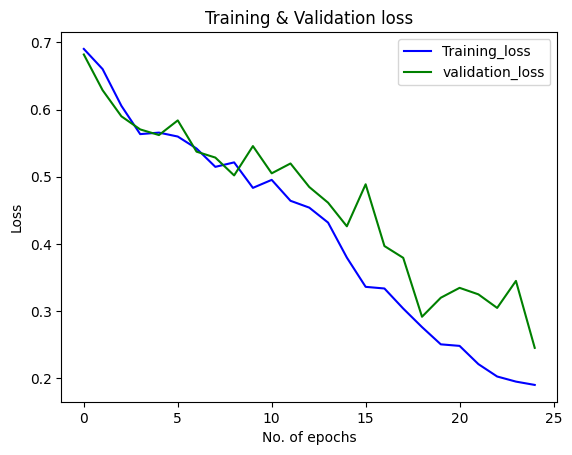

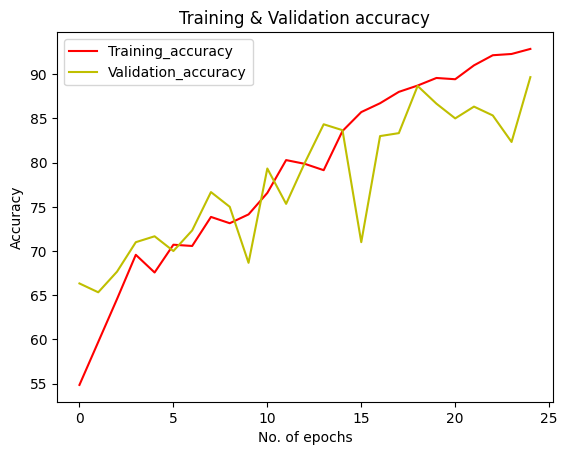

In [70]:
# visualization the loss and accuracy
plt.plot(range(NUM_EPOCHS), Total_training_loss, 'b-', label='Training_loss')
plt.plot(range(NUM_EPOCHS), Total_validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(NUM_EPOCHS), Total_training_accuracy, 'r-', label='Training_accuracy')
plt.plot(range(NUM_EPOCHS), Total_validation_accuracy, 'y-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# c=0
# d=0
# for i in labels:
#     if i == 0:
#         c += 1
#     else:
#         d += 1
# c,d

8. Save model1 weight

In [71]:
torch.save(model.state_dict(), 'NOT_preprocessing_model1-1.h5')

9. load weight and **預測**測試集

- load model weight

In [75]:
model = MyCNN()
# load the model's weight and bias
model.load_state_dict(torch.load('model1-1.h5'))
model.eval() # for predict

MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

- 存入測試檔

In [76]:
# Assuming you have defined the 'spectrogram_images_train' folder and transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load Images from a Folder
image_folder_path = 'spectrogram_images_train_for_test_part1'
image_paths = [os.path.join(image_folder_path, filename) for filename in os.listdir(image_folder_path)]

# Load Labels
# Assuming 'train_df' has columns 'filename' and 'target'
# skip the "spec_" and ".png"
labels = [train_df[train_df["filename"] == os.path.basename(path)[5:-4]]["target"].values[0] for path in image_paths]

# Apply Transformations and convert to tensors
images = [transform(Image.open(path).convert('RGB')) for path in image_paths]

# it is used to convert the list of individual image tensors into a single tensor.
tensor_images = torch.stack(images)  # Convert the list of tensors to a single tensor

Final_test_data = tensor_images.type(torch.float32)


In [77]:
Final_test_data[0].shape

torch.Size([3, 128, 128])

In [80]:
def testing(model, data, labels):
    predict_result = model(data)
    probs = torch.nn.functional.softmax(predict_result, dim=1)
    _, predicted = torch.max(probs, 1) # get the predicted classes by finding the index of the maximum value along dimension 1. 
    # Convert labels to a tensor if they are not already
    labels = torch.tensor(labels).clone().detach()

    total = len(labels)
    correct = (predicted == labels).sum().item()

    print(f'Test data accuracy: {(correct / total) * 100 :.2f}%')

testing(model, Final_test_data, labels)

Test data accuracy: 89.40%


C:\Users\User\AppData\Local\Temp\ipykernel_2372\4105925443.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).clone().detach()
